In [1]:
!pip install keras==2.3.1
!pip install tensorflow==2.1.0
!pip install plot_keras_history

In [2]:
import pandas as pd
import numpy as np

import tensorflow as tf
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout, Flatten, MaxPooling1D, Input, Concatenate
from tensorflow.keras import regularizers
from tensorflow.keras.regularizers import l1,l2

from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

import matplotlib.pyplot as plt
from plot_keras_history import plot_history

Using TensorFlow backend.


In [3]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)

c:\anaconda\envs\pyakc\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\anaconda\envs\pyakc\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
c:\anaconda\envs\pyakc\lib\site-packages\ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\anaconda\envs\pyakc\lib\site-packages\ipykernel_launcher.py:43

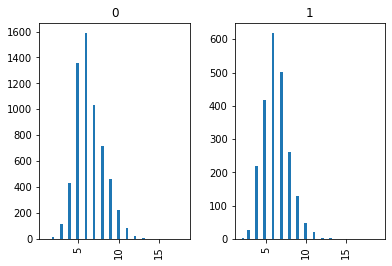

<Figure size 432x288 with 0 Axes>

In [4]:
#Data Loading

news=pd.read_csv('name_genders_train.csv')
news.head()
news = news.sample(frac=1).reset_index(drop=True)
a = news.groupby("gender")
a.head()
a.describe()
y=news['gender']
X=news['name']


for index,gender in enumerate(y):
    if gender=='Female' or gender=='female':
        y[index]=1
    else:
        y[index]=0
    
##check the length to determine the document length for DNN

length=news['name'].apply(len)
news=news.assign(Length=length)

#Plot the distribution of the document length for each category

news.hist(column='Length',by='gender',bins=50)

plt.figure()

MAX_LEN=20

##load names from different source as fresh test data

newtest=pd.read_csv('name_test.csv')
y_newtest=newtest['gender']
X_newtest=newtest['name']


for index,gender in enumerate(y_newtest):
    if gender=='Female' or gender=='female':
        y_newtest[index]=1
    else:
        y_newtest[index]=0

In [5]:
#Data Preparation

text_train, text_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

#create class weight dict
#If 'balanced', class weights will be given by n_samples / (n_classes * np.bincount(y)

class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
class_weights_d = dict(enumerate(class_weights))


tokenizer = Tokenizer(num_words=None,lower=True, char_level=True, oov_token='UNK')
tokenizer.fit_on_texts(text_train)
X_train = tokenizer.texts_to_sequences(text_train)
X_test = tokenizer.texts_to_sequences(text_test)
X_newtest = tokenizer.texts_to_sequences(X_newtest)


word_index = tokenizer.word_index
vocab_size = len(word_index) + 1  # Adding 1 because of reserved 0 index
maxlen = MAX_LEN 

#Padding the sentences
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)
X_newtest = pad_sequences(X_newtest, padding='post', maxlen=maxlen)

c:\anaconda\envs\pyakc\lib\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass classes=[0 1], y=5322    0
6764    0
1626    0
6386    1
1173    0
       ..
2895    0
7813    1
905     0
5192    0
235     0
Name: gender, Length: 5826, dtype: object as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


In [6]:
#Define Basic model with hidden_dim=32
model = Sequential()
model.add(Dense(32, input_dim=maxlen, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
#optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)#by default 
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                672       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 705
Trainable params: 705
Non-trainable params: 0
_________________________________________________________________


Training Accuracy: 0.6686
Valuating Accuracy:  0.6476
{'val_loss': [0.7338321638861608, 0.7007083541209763, 0.6741456972344857, 0.6446631989528716, 0.7358241146881674, 0.6583358641619868, 0.6100477404149475, 0.656301669325884, 0.6274910069820067, 0.6217397672202906], 'val_accuracy': [0.5654785633087158, 0.5694833993911743, 0.5971165299415588, 0.633560299873352, 0.48778533935546875, 0.6055266261100769, 0.6692030429840088, 0.607929527759552, 0.6419703364372253, 0.6475771069526672], 'loss': [1.082663225444207, 0.7410109536245931, 0.7089106950038002, 0.6917387095260489, 0.6786619251305567, 0.674625543560967, 0.6665793091846502, 0.6622739457159242, 0.6548792826241331, 0.6516680987663708], 'accuracy': [0.52111226, 0.5442842, 0.5545829, 0.56951594, 0.57518023, 0.5753519, 0.5918297, 0.5986955, 0.61362857, 0.60315824]}


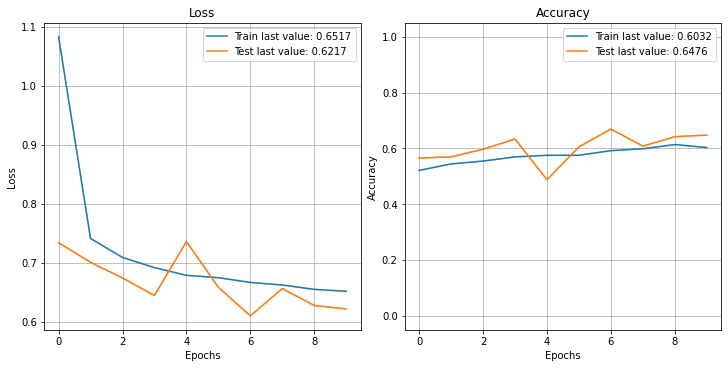

In [7]:
#train model with differnt epochs
#epochs=10
hist = model.fit(X_train, y_train,
                    class_weight = class_weights_d,
                    epochs=10,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=50)

loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Valuating Accuracy:  {:.4f}".format(accuracy))
plot_history(hist.history)
print(hist.history)


Training Accuracy: 0.7575
Valuating Accuracy:  0.7173
Testing Accuracy:  0.6559


(<Figure size 720x360 with 2 Axes>,
 array([<AxesSubplot:title={'center':'Loss'}, xlabel='Epochs', ylabel='Loss'>,
        <AxesSubplot:title={'center':'Accuracy'}, xlabel='Epochs', ylabel='Accuracy'>],
       dtype=object))

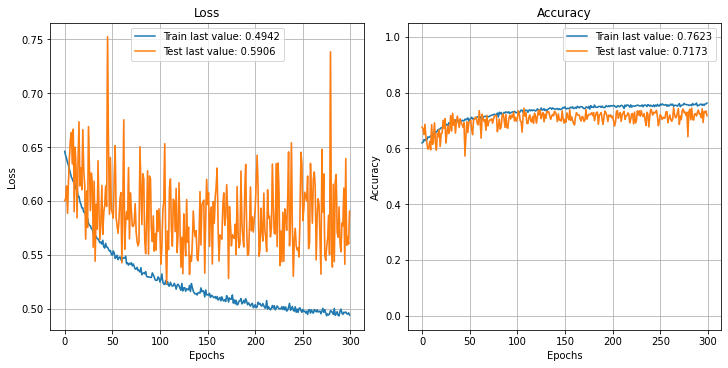

In [8]:

#epochs=300
hist = model.fit(X_train, y_train,
                    class_weight = class_weights_d,
                    epochs=300,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=50)

loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Valuating Accuracy:  {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_newtest, y_newtest, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(hist.history)

In [9]:
##In case of underfitting 
##making model more complex 
def MLP(hidden_dim, num_epochs=100):
    
    model = Sequential()
    model.add(Dense(hidden_dim, input_dim=maxlen, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
    
    hist = model.fit(X_train, y_train,
                    class_weight = class_weights_d,
                    epochs=num_epochs,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=50)
    #model.save(hidden_dim.h5)
    
    loss, accuracy = model.evaluate(X_newtest, y_newtest, verbose=True)
    
    return hist.history, loss, accuracy

651/651 [==============================] - 0s 38us/step


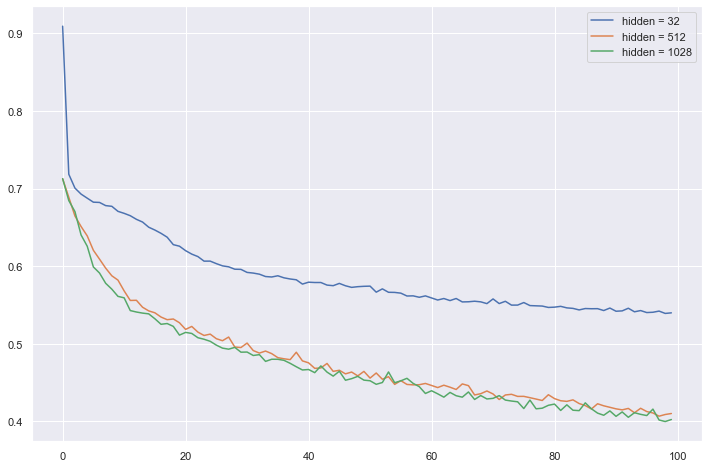

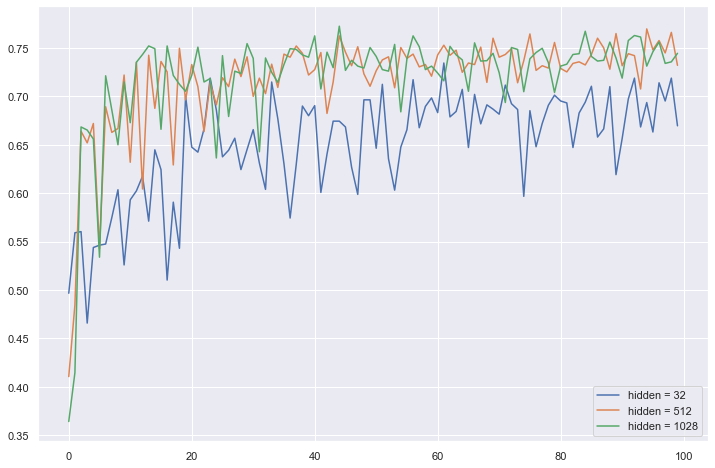

Testing Accuracy 512:  0.6636
Testing Accuracy 1028:  0.6912


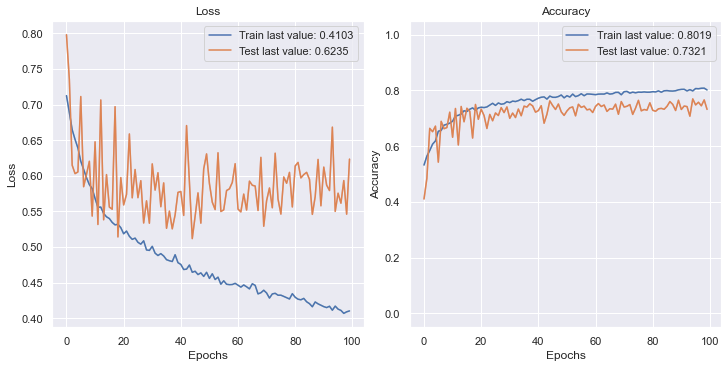

In [10]:
#Increase the hidden dims

hist_h32,loss_h32,acc_h32 = MLP(32)
hist_h512,loss_h512,acc_h512 = MLP(512)
hist_h1028,loss_h1028,acc_h1028 = MLP(1028)
#hist_hmax,loss_hmax,acc_max = MLP(100000)

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.set_style("darkgrid")
sns.set(rc={'figure.figsize':(12, 8)})

plt.plot(hist_h32['loss'], label='hidden = 32')
plt.plot(hist_h512['loss'], label='hidden = 512')
plt.plot(hist_h1028['loss'], label='hidden = 1028')
#plt.plot(hist_hmax['loss'], label='hidden = max')
plt.legend(loc='upper right')
plt.show()


plt.plot(hist_h32['val_accuracy'], label='hidden = 32')
plt.plot(hist_h512['val_accuracy'], label='hidden = 512')
plt.plot(hist_h1028['val_accuracy'], label='hidden = 1028')
#plt.plot(hist_hmax['val_accuracy'], label='hidden = max')
plt.legend(loc='lower right')
plt.show()


plot_history(hist_h512)
print("Testing Accuracy 512:  {:.4f}".format(acc_h512))
print("Testing Accuracy 1028:  {:.4f}".format(acc_h1028))

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 512)               10752     
_________________________________________________________________
dense_10 (Dense)             (None, 64)                32832     
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 65        
Total params: 43,649
Trainable params: 43,649
Non-trainable params: 0
_________________________________________________________________
Training Accuracy: 0.8690
Valuating Accuracy:  0.7361
Testing Accuracy:  0.5945


(<Figure size 720x360 with 2 Axes>,
 array([<AxesSubplot:title={'center':'Loss'}, xlabel='Epochs', ylabel='Loss'>,
        <AxesSubplot:title={'center':'Accuracy'}, xlabel='Epochs', ylabel='Accuracy'>],
       dtype=object))

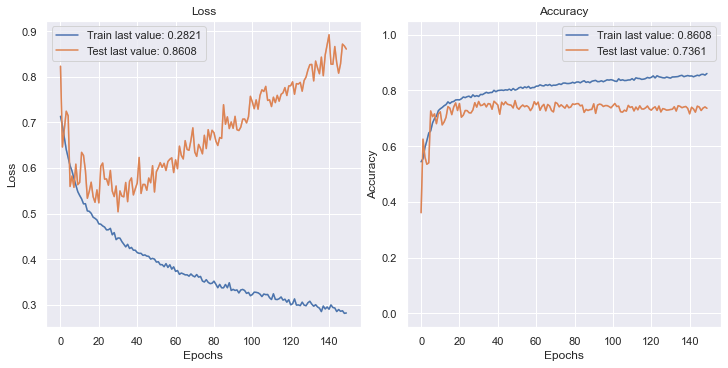

In [11]:
##Still underfitting ? Add more layers

model = Sequential()
model.add(Dense(512, input_dim=maxlen, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

#epochs=150
hist = model.fit(X_train, y_train,
                    class_weight = class_weights_d,
                    epochs=150,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=50)

loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Valuating Accuracy:  {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_newtest, y_newtest, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

plot_history(hist.history)


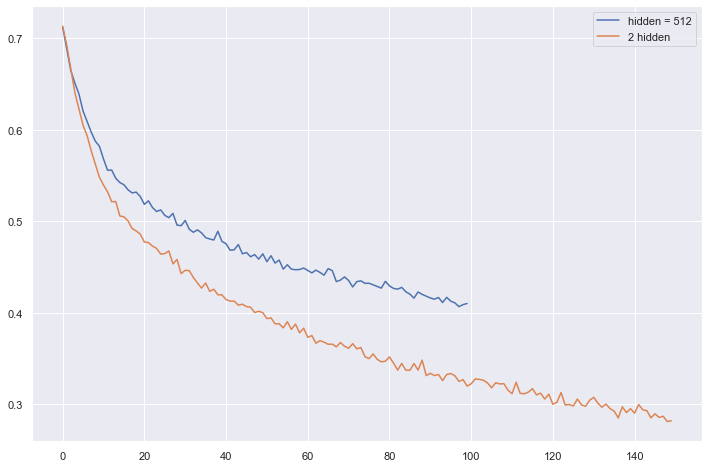

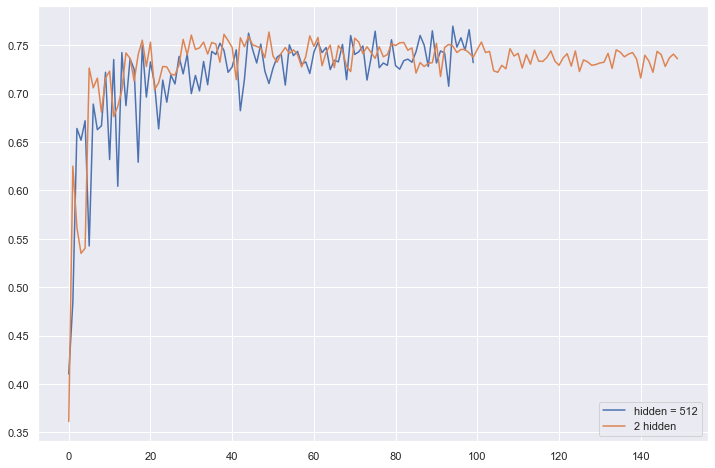

In [12]:

plt.plot(hist_h512['loss'], label='hidden = 512')
plt.plot(hist.history['loss'], label='2 hidden ')
plt.legend(loc='upper right')
plt.show()

plt.plot(hist_h512['val_accuracy'], label='hidden = 512')
plt.plot(hist.history['val_accuracy'], label='2 hidden ')
plt.legend(loc='lower right')
plt.show()

In [13]:
#Small network underfits (longer to converge)
#larger network easier to converge

c:\anaconda\envs\pyakc\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\anaconda\envs\pyakc\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
c:\anaconda\envs\pyakc\lib\site-packages\ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\anaconda\envs\pyakc\lib\site-packages\ipykernel_launcher.py:44: SettingWith

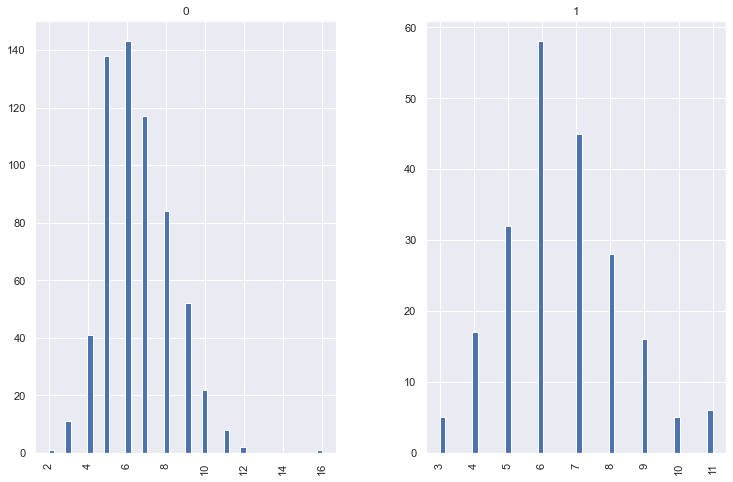

<Figure size 864x576 with 0 Axes>

In [15]:
#To simulate the overfitting, reduce the dataset to 10%
#re-do preprocessing

news=pd.read_csv('name_genders_train.csv')
news.head()
news = news.sample(frac=0.1).reset_index(drop=True)
a = news.groupby("gender")
a.head()
a.describe()
y=news['gender']
X=news['name']


for index,gender in enumerate(y):
    if gender=='Female' or gender=='female':
        y[index]=1
    else:
        y[index]=0
    
##check the length to determine the document length for DNN

length=news['name'].apply(len)
news=news.assign(Length=length)

#Plot the distribution of the document length for each category

news.hist(column='Length',by='gender',bins=50)

plt.figure()

MAX_LEN=20

##load names from different source as fresh test data

newtest=pd.read_csv('name_test.csv')
y_newtest=newtest['gender']
X_newtest=newtest['name']


for index,gender in enumerate(y_newtest):
    if gender=='Female' or gender=='female':
        y_newtest[index]=1
    else:
        y_newtest[index]=0


text_train, text_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

#create class weight dict
#If 'balanced', class weights will be given by n_samples / (n_classes * np.bincount(y)

class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
class_weights_d = dict(enumerate(class_weights))


tokenizer = Tokenizer(num_words=None,lower=True, char_level=True, oov_token='UNK')
tokenizer.fit_on_texts(text_train)
X_train = tokenizer.texts_to_sequences(text_train)
X_test = tokenizer.texts_to_sequences(text_test)
X_newtest = tokenizer.texts_to_sequences(X_newtest)


word_index = tokenizer.word_index
vocab_size = len(word_index) + 1  # Adding 1 because of reserved 0 index
maxlen = MAX_LEN 

#Padding the sentences
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)
X_newtest = pad_sequences(X_newtest, padding='post', maxlen=maxlen)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 256)               5376      
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 257       
Total params: 5,633
Trainable params: 5,633
Non-trainable params: 0
_________________________________________________________________
Testing Accuracy:  0.4624


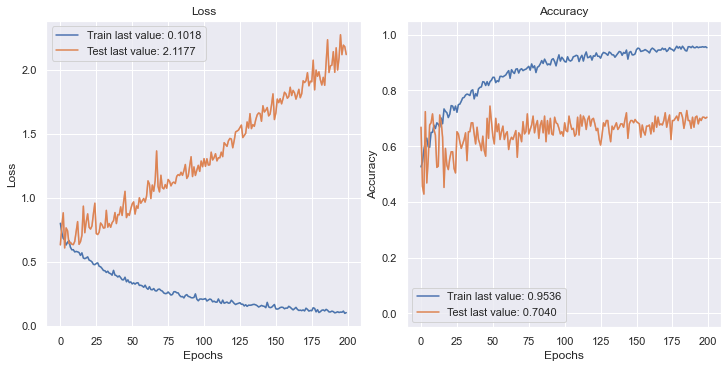

In [16]:
#Try the model with small dataset

model = Sequential()
model.add(Dense(256, input_dim=maxlen, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

hist = model.fit(X_train, y_train,
                    class_weight = class_weights_d,
                    epochs=200,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=5).history

plot_history(hist)

loss, accuracy = model.evaluate(X_newtest, y_newtest, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

In [17]:
#######################################################
#Overfitting
#Too large network overfits
#Tooooooo large network don't train properly at all.
#####################################################

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 256)               5376      
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 257       
Total params: 5,633
Trainable params: 5,633
Non-trainable params: 0
_________________________________________________________________
Testing Accuracy:  0.5269


(<Figure size 720x360 with 2 Axes>,
 array([<AxesSubplot:title={'center':'Loss'}, xlabel='Epochs', ylabel='Loss'>,
        <AxesSubplot:title={'center':'Accuracy'}, xlabel='Epochs', ylabel='Accuracy'>],
       dtype=object))

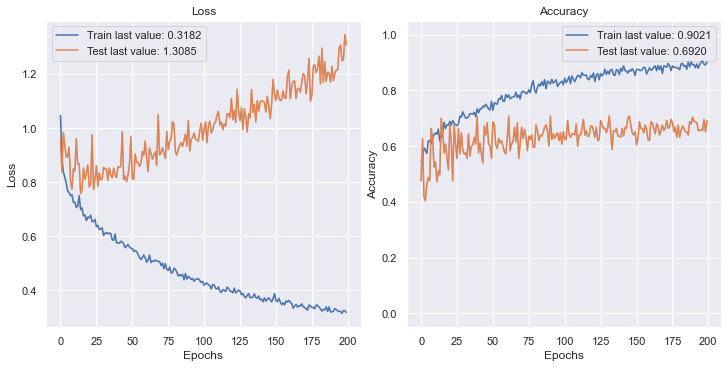

In [18]:
#Add regularizer 
model_reg = Sequential()
model_reg.add(Dense(256, input_dim=maxlen, activation='relu',kernel_regularizer=l1(0.001)))
model_reg.add(Dense(1, activation='sigmoid'))
model_reg.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model_reg.summary()

hist_reg = model_reg.fit(X_train, y_train,
                    class_weight = class_weights_d,
                    epochs=200,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=5).history

loss, accuracy = model_reg.evaluate(X_newtest, y_newtest, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

plot_history(hist_reg)



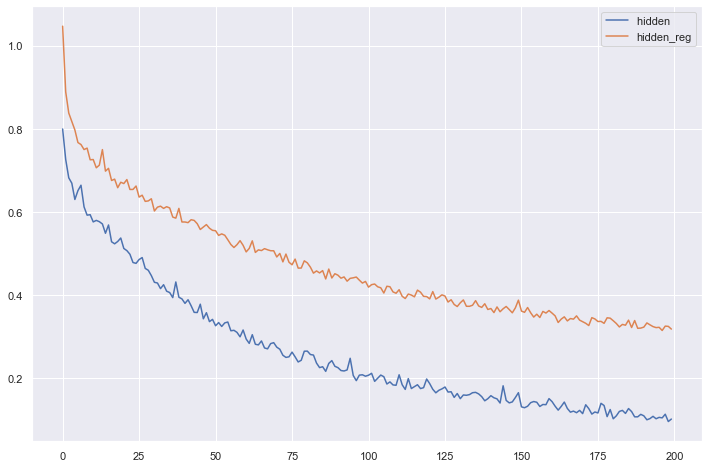

In [19]:
plt.plot(hist['loss'], label='hidden ')
plt.plot(hist_reg['loss'], label='hidden_reg')
plt.legend(loc='upper right')
plt.show()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 256)               5376      
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 257       
Total params: 5,633
Trainable params: 5,633
Non-trainable params: 0
_________________________________________________________________
Testing Accuracy:  0.4808


(<Figure size 720x360 with 2 Axes>,
 array([<AxesSubplot:title={'center':'Loss'}, xlabel='Epochs', ylabel='Loss'>,
        <AxesSubplot:title={'center':'Accuracy'}, xlabel='Epochs', ylabel='Accuracy'>],
       dtype=object))

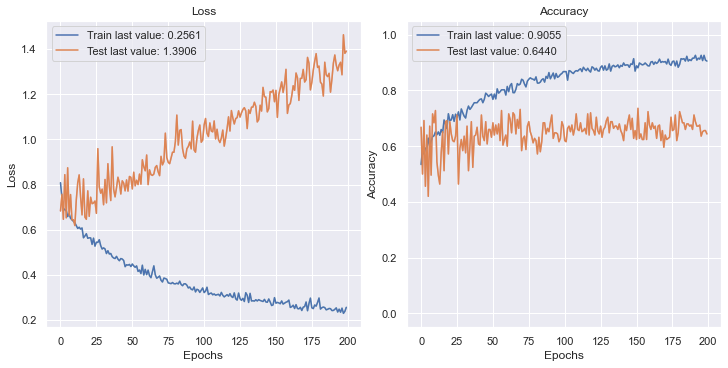

In [20]:
#Add Dropout 
model_reg_dp = Sequential()
model_reg_dp.add(Dense(256, input_dim=maxlen, activation='relu',kernel_regularizer=l2(0.001)))
model_reg_dp.add(Dropout(0.01))
model_reg_dp.add(Dense(1, activation='sigmoid'))
model_reg_dp.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model_reg_dp.summary()

hist_dp_reg = model_reg_dp.fit(X_train, y_train,
                    class_weight = class_weights_d,
                    epochs=200,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=5).history

loss, accuracy = model_reg_dp.evaluate(X_newtest, y_newtest, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

plot_history(hist_dp_reg)



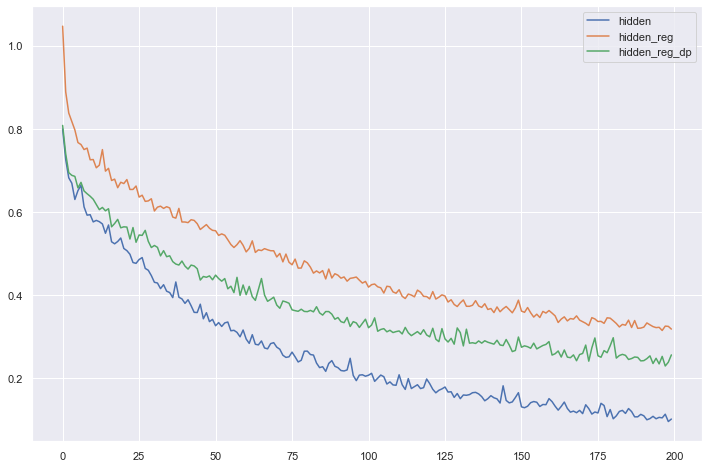

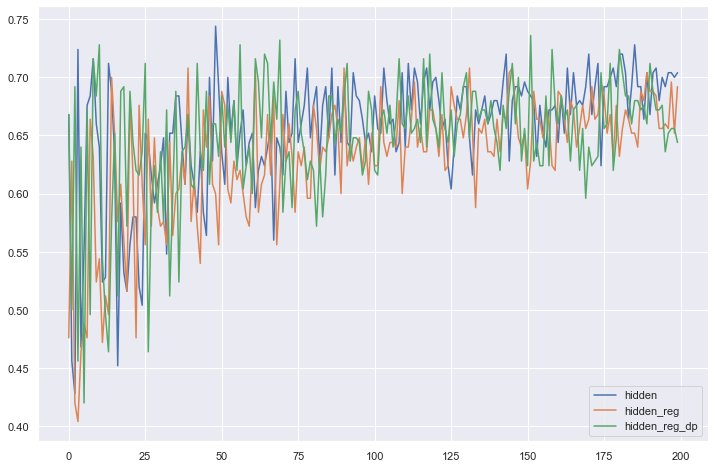

In [21]:
plt.plot(hist['loss'], label='hidden')
plt.plot(hist_reg['loss'], label='hidden_reg')
plt.plot(hist_dp_reg['loss'], label='hidden_reg_dp')
plt.legend(loc='upper right')
plt.show()

plt.plot(hist['val_accuracy'], label='hidden')
plt.plot(hist_reg['val_accuracy'], label='hidden_reg')
plt.plot(hist_dp_reg['val_accuracy'], label='hidden_reg_dp')
plt.legend(loc='lower right')
plt.show()